In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Import Data

In [3]:
X_train = pd.read_csv('data_v1/train_all_feature.csv')

In [4]:
X_test= pd.read_csv('data_v1/test_all_feature.csv')

In [5]:
y_train = pd.read_csv('data_v1/y_train_new.csv')

In [6]:
y_test = pd.read_csv('data_v1/y_test_new.csv')

In [7]:
display(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4328, 105)

(1082, 105)

(4328, 1)

(1082, 1)

In [8]:
X_train.set_index('Provider',inplace = True)

In [9]:
X_test.set_index('Provider',inplace = True)

In [10]:
y_train = y_train.iloc[:,0].ravel() 

In [11]:
y_test = y_test.iloc[:,0].ravel()

In [12]:
# There are two null values under DeductibleAmtPaid_mean and DeductibleAmtPaid_max for PRV54673
# Fillna with -99
X_test.DeductibleAmtPaid_mean.fillna(0, inplace = True)
X_test.DeductibleAmtPaid_max.fillna(0, inplace = True)

### 2. Original Dataset with balanced class weights, tuned hyperparameters

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
steps = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', class_weight = 'balanced',random_state=42,max_iter=10000))]
model = Pipeline(steps)

In [14]:
train_scores = cross_val_score(model, X_train, y_train, scoring = 'average_precision', cv=5)
train_scores

array([0.88174766, 0.86323815, 0.80278395, 0.73953828, 0.75776653])

In [15]:
train_scores.mean()

0.8090149141291929

In [16]:
model.fit(X_train, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

In [17]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

In [18]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)

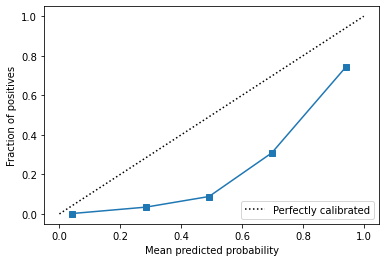

In [19]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_train_prob_1 = model.predict_proba(X_train)[:, 1]
prob_true, prob_pred = calibration_curve(y_train, y_train_prob_1, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_train_prob_1)
disp.plot()

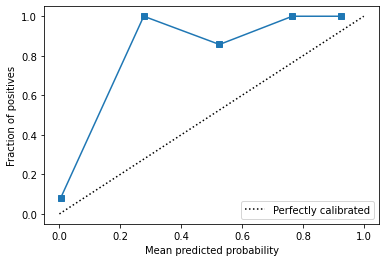

In [20]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_test_prob_1 = model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_test_prob_1, n_bins=5)
disp = CalibrationDisplay(prob_true, prob_pred, y_test_prob_1)
disp.plot()

Test PR-AUC is 0.92
min threshold:0.00 max threshold:0.98


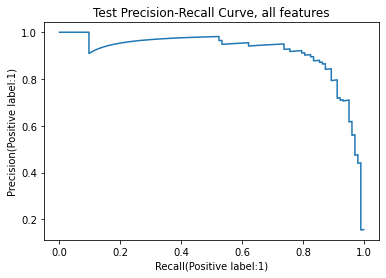

In [21]:
from sklearn.metrics import auc,plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

y_score1 = y_test_proba[:, 1]
test_precision1, test_recall1, test_thresholds1 = precision_recall_curve(y_test, y_score1)
test_auc_precision_recall1 = auc(test_recall1, test_precision1)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(test_thresholds1)), 'max threshold:{:.2f}'.format(max(test_thresholds1)))

plt.plot(test_recall1, test_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, all features')
plt.show()

Test PR-AUC is 0.85
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, all features')

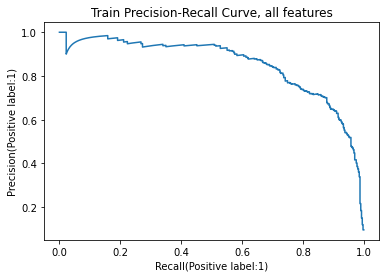

In [22]:
# plot train PR Curve 
train_precision1, train_recall1, train_thresholds1 = precision_recall_curve(y_train, y_train_proba[:, 1])
train_auc_precision_recall1 = auc(train_recall1, train_precision1)
print('Test PR-AUC is {:.2f}'.format(train_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(train_thresholds1)), 'max threshold:{:.2f}'.format(max(train_thresholds1)))

plt.plot(train_recall1, train_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, all features')

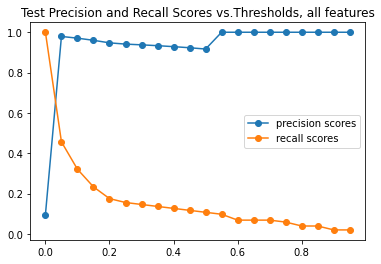

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores = []
recall_scores = []

for i in range(len(thresholds)):
    y_test_pred_new = (model.predict_proba(X_test)[:,1]>thresholds[i]).astype(int)
    prec_scores.append(precision_score(y_test, y_test_pred_new))
    recall_scores.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, all features')
plt.show()

In [28]:
importances = model.named_steps['logreg'].coef_[0]
features = model.feature_names_in_
logreg_importances = pd.Series(importances, index = features)
logreg_importances.sort_values(ascending = False)

TotalTeDiagCode                   2.286210
TotalTeProcCode                   1.217291
MaxHospitalDays                   1.194729
MaxDiagCodeNumPerClaim            0.985291
ClmsperBene                       0.535640
                                    ...   
MeanLowFreqDiagCodeNumPerClaim   -0.375553
MajorRace                        -0.405068
uniqBeneCount                    -0.451041
MedianHospitalDays               -0.743125
MeanProcCodeNumPerClaim          -0.889669
Length: 104, dtype: float64

In [29]:
#fig = plt.figure(figsize = (15,6))
#logreg_importances2.plot.bar(title = 'Feature Importance with balanced class weight')

In [30]:
importances_abs = np.absolute(model.named_steps['logreg'].coef_[0])
logreg_importances_abs = pd.Series(importances_abs, index = features)
top30features = logreg_importances_abs.sort_values(ascending = False)[:30].index

In [31]:
top30features = list(top30features)

In [32]:
logreg_importances.loc[top30features]

TotalTeDiagCode                      2.286210
TotalTeProcCode                      1.217291
MaxHospitalDays                      1.194729
MaxDiagCodeNumPerClaim               0.985291
MeanProcCodeNumPerClaim             -0.889669
MedianHospitalDays                  -0.743125
ClmsperBene                          0.535640
uniqBeneCount                       -0.451041
totalDiagCode_42731                  0.425415
MajorRace                           -0.405068
totalDiagCode_2589                   0.394256
MeanLowFreqDiagCodeNumPerClaim      -0.375553
OPAnnualDeductibleAmt_sum            0.374136
InClmsPct                           -0.345850
TotalInscClaimAmtReimbursed          0.338991
totalDiagCode_41401                  0.331226
OPAnnualReimbursementAmt_sum         0.328806
Chronic_Heartfailure_Frac            0.327246
Chronic_KidneyDisease_Frac           0.310395
MaxInscClaimAmtReimbursed            0.279216
totalDiagCode_2724                  -0.278527
DeductibleAmtPaid_mean            

Text(0.5, 0, 'coefficient')

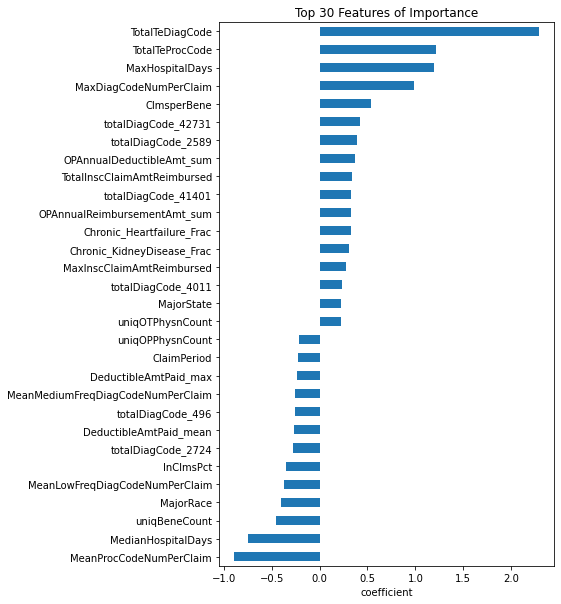

In [33]:
fig = plt.figure(figsize = (6,10))
logreg_importances.loc[top30features].sort_values(ascending = True).plot.barh(title = 'Top 30 Features of Importance')
plt.xlabel('coefficient')

<AxesSubplot:title={'center':'Top 30 Features of Importance'}>

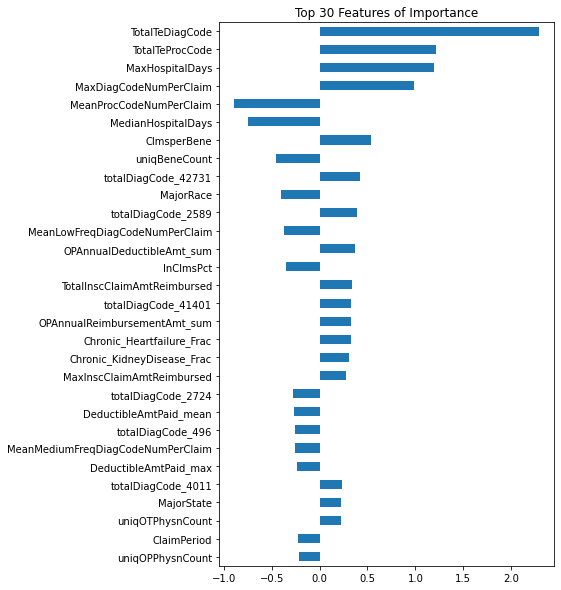

In [34]:
fig = plt.figure(figsize = (6,10))
logreg_importances.loc[top30features][::-1].plot.barh(title = 'Top 30 Features of Importance')

In [35]:
top50features = logreg_importances_abs.sort_values(ascending = False)[:50].index

In [36]:
top50features = list(top50features)

## Logistic Regression with Top50Features

In [37]:
X_train_top50 = X_train[top50features]

In [38]:
X_test_top50 = X_test[top50features]

In [39]:
display(X_train_top50.shape, X_test_top50.shape)

(4328, 50)

(1082, 50)

In [40]:
display(y_train.shape, y_test.shape)

(4328,)

(1082,)

In [41]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps2 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model2 = Pipeline(steps2)
# model2_gsv = GridSearchCV(model2,param_grid,cv = 5, scoring = 'average_precision')
# model2_gsv.fit(X_train_top50, y_train)

In [42]:
# model2_gsv.best_params_

In [43]:
steps2 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'saga', class_weight = 'balanced',random_state=42,max_iter=10000))]
model2 = Pipeline(steps2)

In [44]:
train_scores2 = cross_val_score(model2, X_train_top50, y_train, scoring = 'average_precision', cv=5)

In [45]:
train_scores2.mean()

0.8260785259103492

In [46]:
model2.fit(X_train_top50, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='saga'))])

In [47]:
y_train_pred2 = model2.predict(X_train_top50)
y_train_proba2 = model2.predict_proba(X_train_top50)

In [48]:
y_test_pred2 = model2.predict(X_test_top50)
y_test_proba2 = model2.predict_proba(X_test_top50)

Test PR-AUC is 0.92
min threshold:0.00 max threshold:0.99


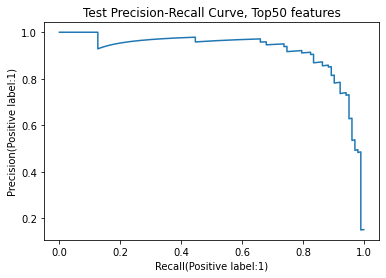

In [49]:
from sklearn.metrics import auc,plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

y_test_score2 = y_test_proba2[:, 1]
test_precision2, test_recall2, test_thresholds2 = precision_recall_curve(y_test, y_test_score2)
test_auc_precision_recall2 = auc(test_recall2, test_precision2)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(test_thresholds2)), 'max threshold:{:.2f}'.format(max(test_thresholds2)))

plt.plot(test_recall2, test_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top50 features')
plt.show()

Test PR-AUC is 0.85
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top50 features')

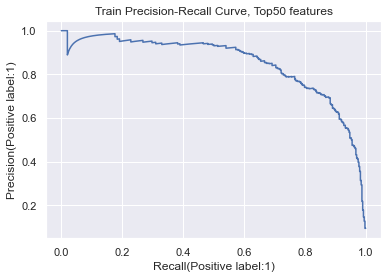

In [102]:
# plot train PR Curve 
train_precision2, train_recall2, train_thresholds2 = precision_recall_curve(y_train, y_train_proba2[:, 1])
train_auc_precision_recall2 = auc(train_recall2, train_precision2)
print('Test PR-AUC is {:.2f}'.format(train_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(train_thresholds2)), 'max threshold:{:.2f}'.format(max(train_thresholds2)))

plt.plot(train_recall2, train_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top50 features')

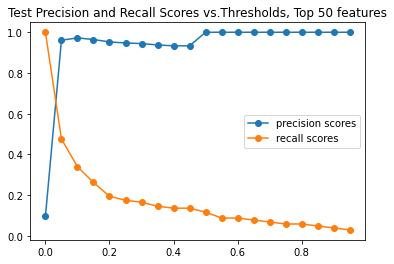

In [50]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores2 = []
recall_scores2 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model2.predict_proba(X_test_top50)[:,1]>thresholds[i]).astype(int)
    prec_scores2.append(precision_score(y_test, y_test_pred_new))
    recall_scores2.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores2, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores2,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 50 features')
plt.show()

### Logistic Regression with Top30Features

In [51]:
X_train_top30 = X_train[top30features]
X_test_top30 = X_test[top30features]

In [52]:
display(X_train_top30.shape, X_test_top30.shape)

(4328, 30)

(1082, 30)

In [53]:
#from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps3 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model3 = Pipeline(steps3)
# model3_gsv = GridSearchCV(model3,param_grid,cv = 5, scoring = 'average_precision')
# model3_gsv.fit(X_train_top30, y_train)

In [54]:
# model3_gsv.best_params_

In [55]:
steps3 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', class_weight = 'balanced',random_state=42,max_iter=10000))]
model3 = Pipeline(steps3)

In [56]:
train_scores3 = cross_val_score(model3, X_train_top30, y_train, scoring = 'average_precision', cv=5)

In [57]:
train_scores3.mean()

0.8285527258593586

In [58]:
model3.fit(X_train_top30, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

In [59]:
y_train_pred3 = model3.predict(X_train_top30)
y_train_proba3 = model3.predict_proba(X_train_top30)

In [60]:
y_test_pred3 = model3.predict(X_test_top30)
y_test_proba3 = model3.predict_proba(X_test_top30)

Test PR-AUC is 0.91
min threshold:0.00 max threshold:0.99


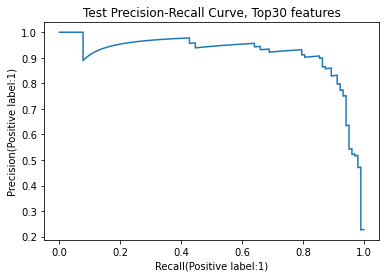

In [61]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

y_test_score3 = y_test_proba3[:, 1]
test_precision3, test_recall3, test_thresholds3 = precision_recall_curve(y_test, y_test_score3)
test_auc_precision_recall3 = auc(test_recall3, test_precision3)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(test_thresholds3)), 'max threshold:{:.2f}'.format(max(test_thresholds3)))

plt.plot(test_recall3, test_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top30 features')
plt.show()

Test PR-AUC is 0.85
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top30 features')

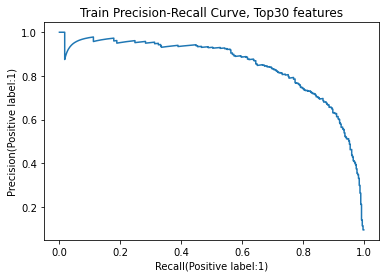

In [62]:
# plot train PR Curve 
train_precision3, train_recall3, train_thresholds3 = precision_recall_curve(y_train, y_train_proba3[:, 1])
train_auc_precision_recall3 = auc(train_recall3, train_precision3)
print('Test PR-AUC is {:.2f}'.format(train_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(train_thresholds3)), 'max threshold:{:.2f}'.format(max(train_thresholds3)))

plt.plot(train_recall3, train_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top30 features')

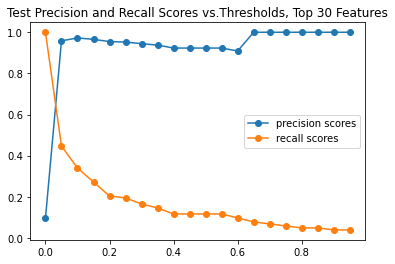

In [63]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores3 = []
recall_scores3 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model3.predict_proba(X_test_top30)[:,1]>thresholds[i]).astype(int)
    prec_scores3.append(precision_score(y_test, y_test_pred_new))
    recall_scores3.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores3, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores3,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 30 Features')
plt.show()

### Logistic Regression with Top 25 Features

In [64]:
top25features = logreg_importances_abs.sort_values(ascending = False)[:25].index
top25features= list(top25features)

In [65]:
X_train_top25 = X_train[top25features]
X_test_top25 = X_test[top25features]

In [66]:
display(X_train_top25.shape, X_test_top25.shape)

(4328, 25)

(1082, 25)

In [82]:
#from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps4 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model4 = Pipeline(steps4)
# model4_gsv = GridSearchCV(model4,param_grid,cv = 5, scoring = 'average_precision')
# model4_gsv.fit(X_train_top25, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [10, 1.0, 0.1, 0.01, 0.005],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']},
             scoring='average_precision')

In [83]:
# model4_gsv.best_params_

{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}

In [67]:
steps4 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'saga', class_weight = 'balanced',random_state=42,max_iter=10000))]
model4 = Pipeline(steps4)

In [68]:
train_scores4 = cross_val_score(model4, X_train_top25, y_train, scoring = 'average_precision', cv=5)

In [69]:
train_scores4.mean()

0.8291072632909661

In [70]:
model4.fit(X_train_top25, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='saga'))])

In [71]:
y_train_pred4 = model4.predict(X_train_top25)
y_train_proba4 = model4.predict_proba(X_train_top25)

In [72]:
y_test_pred4 = model4.predict(X_test_top25)
y_test_proba4 = model4.predict_proba(X_test_top25)

Test PR-AUC is 0.92
min threshold:0.00 max threshold:1.00


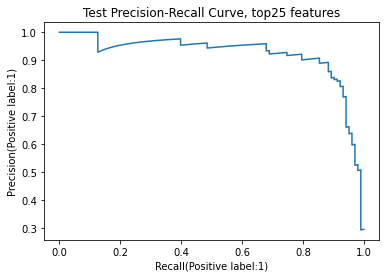

In [73]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

y_test_score4 = y_test_proba4[:, 1]
test_precision4, test_recall4, test_thresholds4 = precision_recall_curve(y_test, y_test_score4)
test_auc_precision_recall4 = auc(test_recall4, test_precision4)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall4))

print('min threshold:{:.2f}'.format(min(test_thresholds4)), 'max threshold:{:.2f}'.format(max(test_thresholds4)))

plt.plot(test_recall4, test_precision4)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, top25 features')
plt.show()

Train PR-AUC is 0.85
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 25 features')

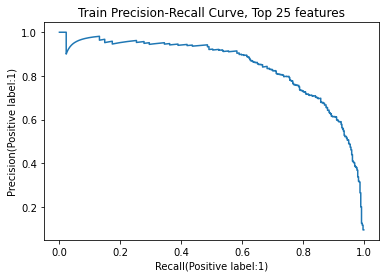

In [74]:
# plot train PR Curve 
train_precision4, train_recall4, train_thresholds4 = precision_recall_curve(y_train, y_train_proba4[:, 1])
train_auc_precision_recall4 = auc(train_recall4, train_precision4)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall4))

print('min threshold:{:.2f}'.format(min(train_thresholds4)), 'max threshold:{:.2f}'.format(max(train_thresholds4)))

plt.plot(train_recall4, train_precision4)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 25 features')

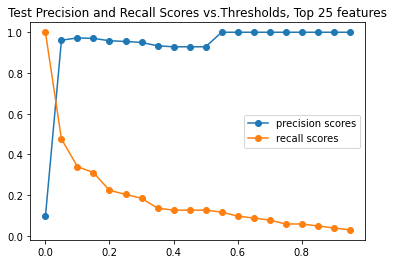

In [75]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores4 = []
recall_scores4 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model4.predict_proba(X_test_top25)[:,1]>thresholds[i]).astype(int)
    prec_scores4.append(precision_score(y_test, y_test_pred_new))
    recall_scores4.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores4, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores4,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 25 features')
plt.show()

### Logistic Regression with Top 15 Features

In [76]:
top15features = logreg_importances_abs.sort_values(ascending = False)[:15].index
top15features= list(top15features)

X_train_top15 = X_train[top15features]
X_test_top15 = X_test[top15features]

display(X_train_top15.shape, X_test_top15.shape)

(4328, 15)

(1082, 15)

In [77]:
#from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps5 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model5 = Pipeline(steps5)
# model5_gsv = GridSearchCV(model5,param_grid,cv = 5, scoring = 'average_precision')
# model5_gsv.fit(X_train_top15, y_train)
# model5_gsv.best_params_

In [78]:
steps5 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', class_weight = 'balanced',random_state=42,max_iter=10000))]
model5 = Pipeline(steps5)
train_scores5= cross_val_score(model5, X_train_top15, y_train, scoring = 'average_precision', cv=5)
train_scores5.mean()

0.8287305004745645

In [79]:
model5.fit(X_train_top15, y_train)

y_train_pred5 = model5.predict(X_train_top15)
y_train_proba5 = model5.predict_proba(X_train_top15)

y_test_pred5 = model5.predict(X_test_top15)
y_test_proba5 = model5.predict_proba(X_test_top15)

Test PR-AUC is 0.92
min threshold:0.00 max threshold:1.00


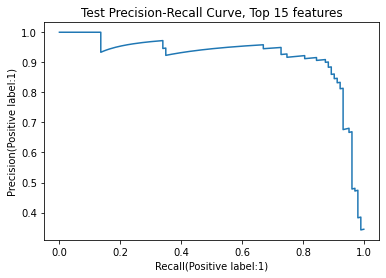

In [80]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

y_test_score5 = y_test_proba5[:, 1]
test_precision5, test_recall5, test_thresholds5 = precision_recall_curve(y_test, y_test_score5)
test_auc_precision_recall5 = auc(test_recall5, test_precision5)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall5))

print('min threshold:{:.2f}'.format(min(test_thresholds5)), 'max threshold:{:.2f}'.format(max(test_thresholds5)))

plt.plot(test_recall5, test_precision5)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 15 features')
plt.show()

Train PR-AUC is 0.84
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 15 features')

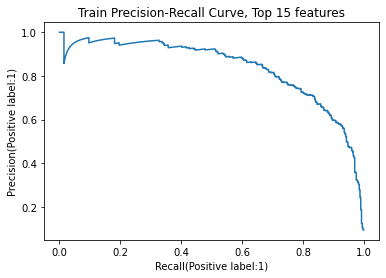

In [81]:
# plot train PR Curve 
train_precision5, train_recall5, train_thresholds5 = precision_recall_curve(y_train, y_train_proba5[:, 1])
train_auc_precision_recall5 = auc(train_recall5, train_precision5)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall5))

print('min threshold:{:.2f}'.format(min(train_thresholds5)), 'max threshold:{:.2f}'.format(max(train_thresholds5)))

plt.plot(train_recall5, train_precision5)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 15 features')

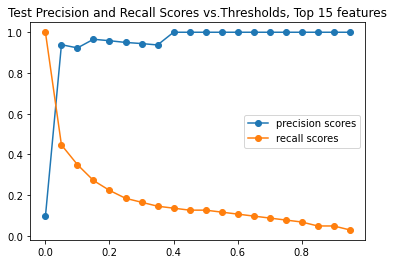

In [82]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores5 = []
recall_scores5 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model5.predict_proba(X_test_top15)[:,1]>thresholds[i]).astype(int)
    prec_scores5.append(precision_score(y_test, y_test_pred_new))
    recall_scores5.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores5, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores5,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 15 features')
plt.show()

### Logistic Regression with Top 10 Features

In [83]:
top10features = logreg_importances_abs.sort_values(ascending = False)[:10].index
top10features= list(top10features)

X_train_top10 = X_train[top10features]
X_test_top10 = X_test[top10features]

display(X_train_top10.shape, X_test_top10.shape)

(4328, 10)

(1082, 10)

In [84]:
#from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps6 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model6 = Pipeline(steps6)
# model6_gsv = GridSearchCV(model6,param_grid,cv = 5, scoring = 'average_precision')
# model6_gsv.fit(X_train_top10, y_train)
# model6_gsv.best_params_

In [85]:
steps6 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 1.0, penalty = 'l2', solver = 'saga', class_weight = 'balanced',random_state=42,max_iter=10000))]
model6 = Pipeline(steps6)
train_scores6= cross_val_score(model6, X_train_top10, y_train, scoring = 'average_precision', cv=5)
train_scores6.mean()

0.8248626099044287

In [86]:
model6.fit(X_train_top10, y_train)

y_train_pred6 = model6.predict(X_train_top10)
y_train_proba6 = model6.predict_proba(X_train_top10)

y_test_pred6 = model6.predict(X_test_top10)
y_test_proba6 = model6.predict_proba(X_test_top10)

Test PR-AUC is 0.89
min threshold:0.00 max threshold:0.97


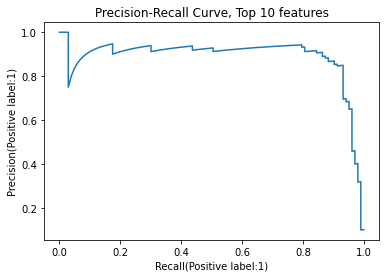

In [87]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

y_test_score6 = y_test_proba6[:, 1]
test_precision6, test_recall6, test_thresholds6 = precision_recall_curve(y_test, y_test_score6)
test_auc_precision_recall6 = auc(test_recall6, test_precision6)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall6))

print('min threshold:{:.2f}'.format(min(test_thresholds6)), 'max threshold:{:.2f}'.format(max(test_thresholds6)))

plt.plot(test_recall6, test_precision6)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve, Top 10 features')
plt.show()

Train PR-AUC is 0.83
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 10 features')

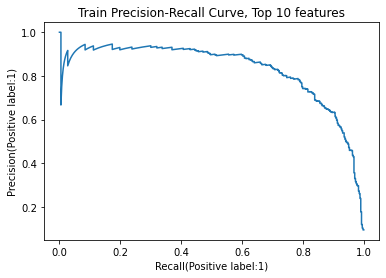

In [88]:
# plot train PR Curve 
train_precision6, train_recall6, train_thresholds6 = precision_recall_curve(y_train, y_train_proba6[:, 1])
train_auc_precision_recall6 = auc(train_recall6, train_precision6)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall6))

print('min threshold:{:.2f}'.format(min(train_thresholds6)), 'max threshold:{:.2f}'.format(max(train_thresholds6)))

plt.plot(train_recall6, train_precision6)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 10 features')

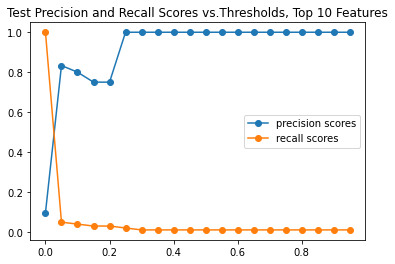

In [89]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores6 = []
recall_scores6 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model6.predict_proba(X_test_top10)[:,1]>thresholds[i]).astype(int)
    prec_scores6.append(precision_score(y_test, y_test_pred_new))
    recall_scores6.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores6, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores6,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 10 Features')
plt.show()

### check collinearity between Top 15 features

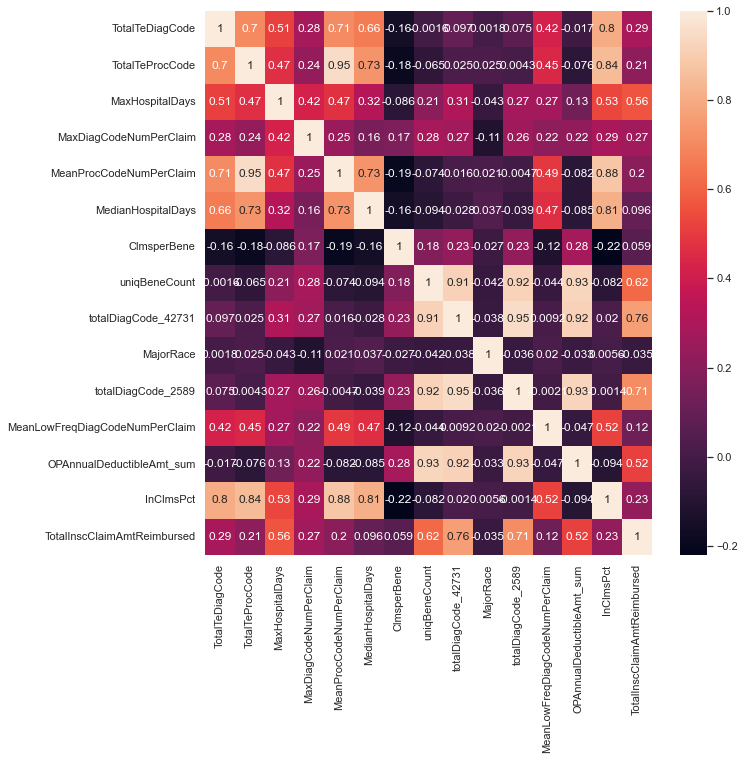

In [106]:
import seaborn as sns
sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(10,10)})
dataplot=sns.heatmap(X_train_top15.corr(method = 'pearson'), annot=True)
plt.show()

OPAnuualDeductibelAmt_sum -- uniqBeneCount -- TotalDiagCode_42731 -- TotalDiagCode_2589
TotalTeProcCode -- MeanProcCodeNumPerClaim

## Remove 4 highly correlated features and re-train logistic Regression

In [90]:
to_be_removed = ['OPAnnualDeductibleAmt_sum','totalDiagCode_42731','totalDiagCode_2589','MeanProcCodeNumPerClaim']
top11features = []
for item in top15features:
    if item not in to_be_removed:
        top11features.append(item)
top11features

['TotalTeDiagCode',
 'TotalTeProcCode',
 'MaxHospitalDays',
 'MaxDiagCodeNumPerClaim',
 'MedianHospitalDays',
 'ClmsperBene',
 'uniqBeneCount',
 'MajorRace',
 'MeanLowFreqDiagCodeNumPerClaim',
 'InClmsPct',
 'TotalInscClaimAmtReimbursed']

In [91]:
X_train_top11 = X_train[top11features]
X_test_top11 = X_test[top11features]

display(X_train_top11.shape, X_test_top11.shape)

(4328, 11)

(1082, 11)

In [163]:
#from sklearn.model_selection import GridSearchCV
# param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

# steps7 = [('rescale', StandardScaler()), 
#           ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
# model7 = Pipeline(steps7)
# model7_gsv = GridSearchCV(model7,param_grid,cv = 5, scoring = 'average_precision')
# model7_gsv.fit(X_train_top11, y_train)
# model7_gsv.best_params_

{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

In [92]:
steps7 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs', class_weight = 'balanced',random_state=42,max_iter=10000))]
model7 = Pipeline(steps7)
train_scores7= cross_val_score(model7, X_train_top11, y_train, scoring = 'average_precision', cv=5)
train_scores7.mean()

0.8163972604328077

In [93]:
model7.fit(X_train_top11, y_train)

y_train_pred7 = model7.predict(X_train_top11)
y_train_proba7 = model7.predict_proba(X_train_top11)

y_test_pred7 = model7.predict(X_test_top11)
y_test_proba7 = model7.predict_proba(X_test_top11)

Test PR-AUC is 0.93
min threshold:0.00 max threshold:1.00


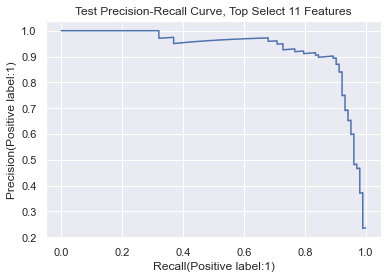

In [97]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

y_test_score7 = y_test_proba7[:, 1]
test_precision7, test_recall7, test_thresholds7 = precision_recall_curve(y_test, y_test_score7)
test_auc_precision_recall7 = auc(test_recall7, test_precision7)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall7))

print('min threshold:{:.2f}'.format(min(test_thresholds7)), 'max threshold:{:.2f}'.format(max(test_thresholds7)))

import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})
plt.plot(test_recall7, test_precision7)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top Select 11 Features')
plt.show()

Test PR-AUC is 0.82
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Select Top 11 features')

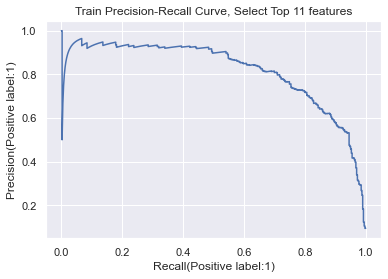

In [98]:
# plot train PR Curve 
train_precision7, train_recall7, train_thresholds7 = precision_recall_curve(y_train, y_train_proba7[:, 1])
train_auc_precision_recall7 = auc(train_recall7, train_precision7)
print('Test PR-AUC is {:.2f}'.format(train_auc_precision_recall7))

print('min threshold:{:.2f}'.format(min(train_thresholds7)), 'max threshold:{:.2f}'.format(max(train_thresholds7)))

plt.plot(train_recall7, train_precision7)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Select Top 11 features')

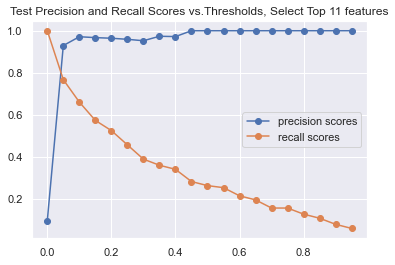

In [99]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores7 = []
recall_scores7 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model7.predict_proba(X_test_top11)[:,1]>thresholds[i]).astype(int)
    prec_scores7.append(precision_score(y_test, y_test_pred_new))
    recall_scores7.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores7, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores7,marker = 'o',label = 'recall scores')
plt.title('Test Precision and Recall Scores vs.Thresholds, Select Top 11 features')
plt.legend()
plt.show()

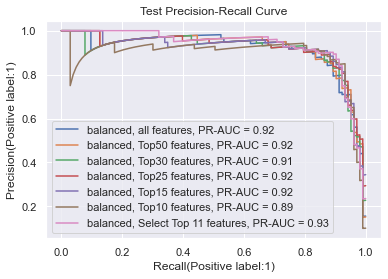

In [100]:
# Summary Test PR-Curve
line1, = plt.plot(test_recall1, test_precision1,label= 'balanced, all features, PR-AUC = 0.92')
line2, = plt.plot(test_recall2, test_precision2,label= 'balanced, Top50 features, PR-AUC = 0.92')
line3, = plt.plot(test_recall3, test_precision3,label= 'balanced, Top30 features, PR-AUC = 0.91')
line4, = plt.plot(test_recall4, test_precision4,label= 'balanced, Top25 features, PR-AUC = 0.92')
line5, = plt.plot(test_recall5, test_precision5,label= 'balanced, Top15 features, PR-AUC = 0.92')
line6, = plt.plot(test_recall6, test_precision6,label= 'balanced, Top10 features, PR-AUC = 0.89')
line7, = plt.plot(test_recall7, test_precision7,label= 'balanced, Select Top 11 features, PR-AUC = 0.93')

plt.legend(handles=[line1, line2,line3, line4, line5, line6, line7])
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve')
plt.show()

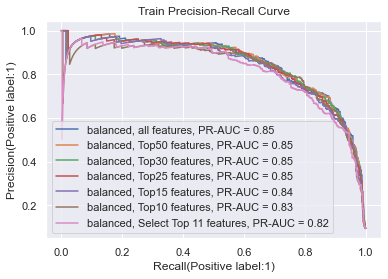

In [103]:
# Summary Train PR Curve
line1, = plt.plot(train_recall1, train_precision1,label= 'balanced, all features, PR-AUC = 0.85')
line2, = plt.plot(train_recall2, train_precision2,label= 'balanced, Top50 features, PR-AUC = 0.85')
line3, = plt.plot(train_recall3, train_precision3,label= 'balanced, Top30 features, PR-AUC = 0.85')
line4, = plt.plot(train_recall4, train_precision4,label= 'balanced, Top25 features, PR-AUC = 0.85')
line5, = plt.plot(train_recall5, train_precision5,label= 'balanced, Top15 features, PR-AUC = 0.84')
line6, = plt.plot(train_recall6, train_precision6,label= 'balanced, Top10 features, PR-AUC = 0.83')
line7, = plt.plot(train_recall7, train_precision7,label= 'balanced, Select Top 11 features, PR-AUC = 0.82')

plt.legend(handles=[line1, line2,line3, line4, line5, line6, line7])
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve')
plt.show()

In [175]:
X_train_top11 = X_train[top11features]

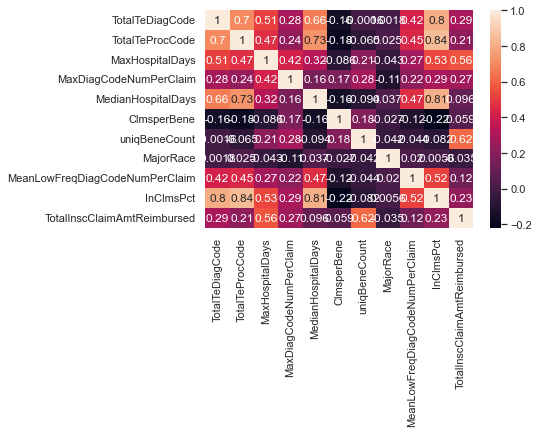

In [176]:
dataplot=sns.heatmap(X_train_top11.corr(method = 'pearson'), annot=True)

In [177]:
top11features

['TotalTeDiagCode',
 'TotalTeProcCode',
 'MaxHospitalDays',
 'MaxDiagCodeNumPerClaim',
 'MedianHospitalDays',
 'ClmsperBene',
 'uniqBeneCount',
 'MajorRace',
 'MeanLowFreqDiagCodeNumPerClaim',
 'InClmsPct',
 'TotalInscClaimAmtReimbursed']

In [128]:
X_train_top11.head()

,TotalTeDiagCode,TotalTeProcCode,MaxHospitalDays,MaxDiagCodeNumPerClaim,MedianHospitalDays,ClmsperBene,uniqBeneCount,MajorRace,MeanLowFreqDiagCodeNumPerClaim,InClmsPct,TotalInscClaimAmtReimbursed
Provider,,,,,,,,,,,
PRV51001,1.166158,1.186518,15.0,9,0.0,1.041667,24,1,0.200000,0.200000,104640
PRV51004,1.144495,1.161067,0.0,9,0.0,1.079710,138,1,0.140940,0.000000,52170
PRV51005,1.174065,1.161067,0.0,10,0.0,2.353535,495,1,0.156223,0.000000,280910
PRV51008,1.144524,1.163394,6.0,10,0.0,1.194444,36,1,0.162791,0.046512,35630
PRV51011,1.141459,1.161067,6.0,9,0.0,1.094340,53,1,0.172414,0.017241,16630


In [129]:
pip install virtualenv

  Using cached virtualenv-20.16.3-py2.py3-none-any.whl (8.8 MB)
Note: you may need to restart the kernel to use updated packages.
